# Machine Learning @ UWr 2021

**Lecture 06**

In previous lecture we have seen how Machine Learning is about buuilding models whitch describe a dataset. In today's lecture we will see the connection between Machine Learning and Statistics and we will learn a formal justification for the least square criterion and for model regularization.

In todays lecture we will be assuming that the data are generated from a probabilistic model:

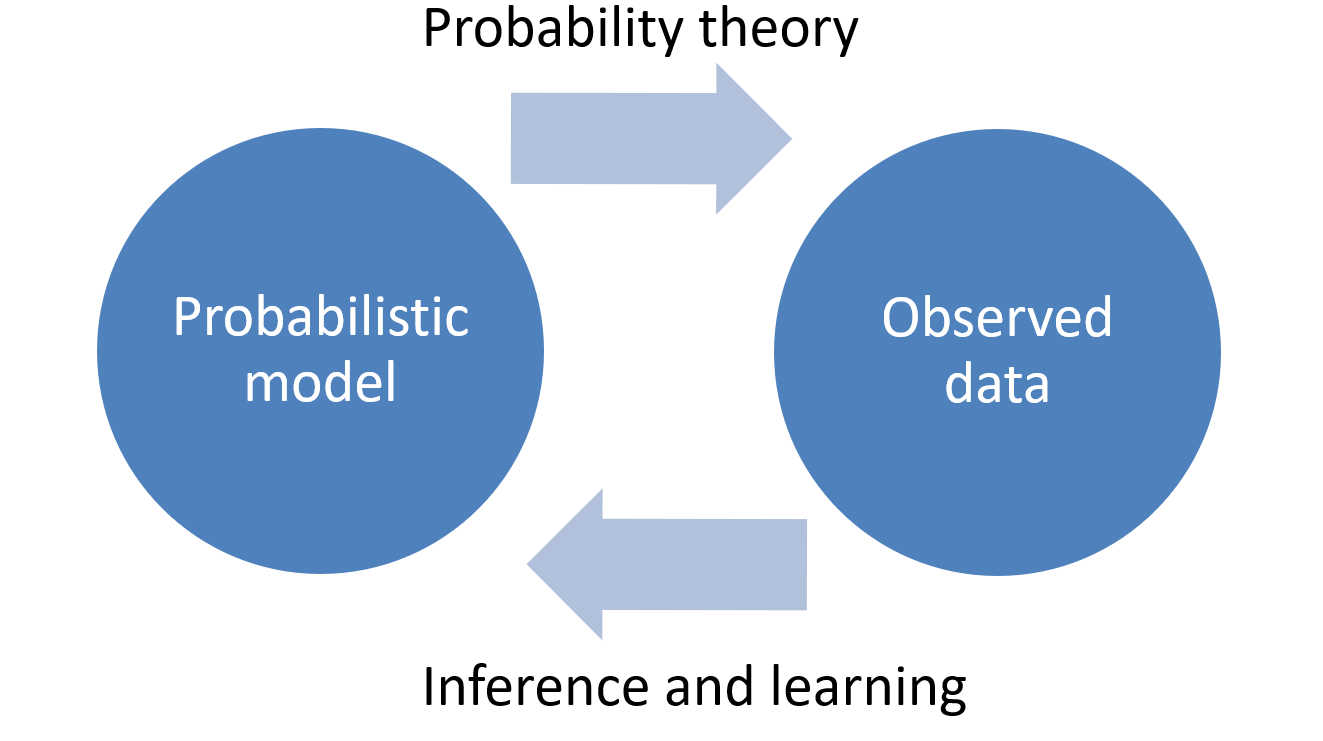

We assume the existence of a model, which exactly describes the process generating our data. Using probability theory, we can sample data from this model.

We can also follow the other arrow and _infer_ the model based on the observed data.

Thus, we can use the language of probabilities to describe models, use the language of statistics to describe our data, and use inference techniques to reason about model based on our observed data.


Before we begin, we must revisit a bit of notation. Plase see the [slides](https://github.com/janchorowski/ml_uwr/blob/fall2020/lectures/03_prob_review.pdf).

## Statistical Inference

We will illustrate the problem of inference using one of the simplest examples: estimating the probability of success of a Bernoulli Random Variable.

Our data contains many observations of a binary Random Variable. It may  model for instance:
- results of tossing a single coing multiple times,
- results of drawing balls from an urn with replacement.

In the example, we will use to understand how polling works. We will now define the polling problem:
1. There exists **a population** of individuals (e.g. voters).
2. Each individual has a voting preference (party A or B).
3. We want to know the fraction $\phi$ of voters that prefer A.
4. But we don't want to ask everyone (which means holding an election)!

This is exactly what polling companies do: they ask a selected group of people, and provide an answer about the whole population.

Please note that even in this simple situatoin we have several different, though related, quantities. It is crutial that you understand them.

The statistical model of the population is described by a single parameter, $\phi$ - the fraction of A's supporters.

We will **model** the polling process as drawing a random person from the population and checking their preference.

Moreover, we will assume that the popluation is so large, and the number of people we poll so little, that we can assume that the draws are made with replacement.

Therefore we assume that the poll results represent several draws from the same [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution). In other words - the RVs representing answers are IID - independent and identically distributed.

The polling model generates us a **data sample**: the set of responses. We can compute some statistics of this sample (recall that we call a *statistic* any value computed from data), for instance:
- the size of the poll $n$,
- the number of A's supporters $A$,
- the mean preference $\bar\phi = \frac{A}{n}$.

Intuitively, the statistics of the sample, especially the fraction $\bar\phi$, are related to parameters of the sampling model. We will now try to formally answer:
1. How are $\phi$ and $\bar\phi$ related?
2. What is our error, how far is $\phi$ from $\bar\phi$?
3. How many persons do we need to ask to achieve a desired error with high probability?

### A polling simulator

Let's now simulate the polling process. We will generate IID random binary values, then count the fraction of observed 1's.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats

In [27]:
phi = 0.55  # The model parameter: true probability p(1)
n = 50  # The sample size
n_sims = 10 # number of simulations

# Simulate a few random draws
sample_means = np.ndarray(n_sims)
for i in range(n_sims):
    sample = np.random.rand(n) < phi  # rand gives us numbers between 0 and 1
    sample_means[i] = sample.sum()/n
    print (f"Drawn {n} samples. Observed {sample.sum()} 1's. "
           f"Empirical mean {1.0*sample.sum()/n:.3f} (model mean: {phi})")

print (f"\nMean of means: ", sample_means.mean())

Drawn 50 samples. Observed 20 1's. Empirical mean 0.400 (model mean: 0.55)
Drawn 50 samples. Observed 33 1's. Empirical mean 0.660 (model mean: 0.55)
Drawn 50 samples. Observed 30 1's. Empirical mean 0.600 (model mean: 0.55)
Drawn 50 samples. Observed 25 1's. Empirical mean 0.500 (model mean: 0.55)
Drawn 50 samples. Observed 30 1's. Empirical mean 0.600 (model mean: 0.55)
Drawn 50 samples. Observed 30 1's. Empirical mean 0.600 (model mean: 0.55)
Drawn 50 samples. Observed 27 1's. Empirical mean 0.540 (model mean: 0.55)
Drawn 50 samples. Observed 20 1's. Empirical mean 0.400 (model mean: 0.55)
Drawn 50 samples. Observed 31 1's. Empirical mean 0.620 (model mean: 0.55)
Drawn 50 samples. Observed 26 1's. Empirical mean 0.520 (model mean: 0.55)

Mean of means:  0.5440000000000002


Not surprisingly, every simulated "poll" returns slightly different results. Our sample size, 50, is quite small, and the observed means typically take values between 0.4 and 0.7. However please not, that while unlikely, the poll could return all zeros, or all ones!

Our first observation is thus: the result of a poll, that is the sample statistic $\bar\phi$ is a Random Variable as well. As such, it will have its very own probability distribution!

### The distribution of $\bar\phi$

Recall that $\bar\phi$ is the fraction of successes (heads, ones, A's supporers) observed in $n$ independent trials.

The number of successes $k$ in $n$ Bernulli trials follows the [Binomial Distribution](https://en.wikipedia.org/wiki/Binomial_distribution):
$$
p\left(k\text{ successes in }n\text{ trials}; n, \phi\right)=\binom{n}{k}\phi^k(1-\phi)^{n-k}.
$$

Where: $k$ is the number of successes, $n$ is a parameter of the distribution, the number of trials and $\phi$ is another parameter - the probability of succes in a single trial.

Since $\bar\phi = k/n$ and $k$ is a discrete RV, we observe that
$$
p\left(\bar\phi = \frac{k}{n}; n, \phi\right) = p\left(k\text{ successes in }n\text{ trials}; n, \phi\right)
$$

Let's verify that this is the case using an experiment!

<ipython-input-37-8b3a9ea48440>:16: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(possible_successes , model.pmf(possible_successes), 'b',


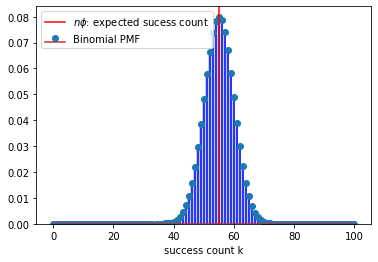

In [37]:
N = 100000  # the number of polls to simulate
n = 100  # the number of trials in a single poll
phi = 0.55  # the probability of success of a single trial

poll_results = np.random.rand(N, n) < phi
k = poll_results.sum(1)  # fraction of successes in each poll

# choose bins such that each observation falls into the middle of some bin
bins = np.arange(-0.5, n+1, 1, dtype='float32')
plt.hist(k, bins=bins, density=True, alpha=0.3)

# now plot the binomial distribution
model = scipy.stats.binom(n=n, p=phi)
possible_successes = np.arange(n + 1)
# plot the PMF - probability mass function
plt.stem(possible_successes , model.pmf(possible_successes), 'b', 
         label='Binomial PMF', use_line_collection=True)
plt.axvline(phi * n, 0, 1, color='r', label=r'$n\phi$: expected sucess count')
plt.legend()
_ = plt.xlabel('success count k')

The plot shows us a histogram of many simuleted poll results. It exactly matches the Binomial distribution. We have also indicated the expected value of the number of sucesses, which equals $n\phi$.

### Statistical Inference: model parameter estimation

In Statistics and Machine Learning we only have access to the sample, in our case to one poll result. The goal is to learn something useful about the unknown population. Here we are interested in the true fraction $\phi$.

To perform this inference we will perform a Maximum Likelihood reasoning:
1. Suppose there is a population with true (*unknown*) fraction $\phi$.
2. We have observed a sample from this population with some *known* sample fraction $\bar\phi$.
3. Our observation has probablity $p(\bar\phi; \phi)$ of happening. We know the formula for this probability, but we don't know $\phi$.
4. However we can ask:
   What $\hat\phi$ would make our observed data sample the most probable?
   Formally, we search for a $\hat\phi$ which maximizes our chances of observing the data we have:
   $$
    \hat\phi = \underset{\Phi}{\operatorname{argmax}}p(\bar\phi; \Phi)
   $$

We will call $\mathcal{L}(\Phi) = p(\bar\phi; \Phi)$ the _likelihood_ of $\Phi$ and we will call its maximizer $\hat\phi$ the maximum likelihood estimator of the population's unknown $\phi$.

There are many $phi$'s above and it sure gets confusing. Let me restate how they are different:
- $\phi$ is a parameter of the true population, we don't know it
- $\bar\phi$ is a statistic computed on our data sample, we know it
- $\Phi$ is any possible value of $\phi$; in our case $\Phi$ is any possible value from $[0,1]$
- $\hat\phi$ is the maximizer of the data likelihood - is the parameter of a hypothetical population which makes the observed data the most likely.

Thus our reasoning assumes that we will estimate (or infer) the true, unknown $\phi$ with a $\hat\phi$ which makes what we have witnessed the most probable.

### Maximum Likelihood Estimation (MLE)

What is left for us is to find $\hat\phi$ or the MLE of $\phi$.

This amounts to finding the maximum of the likelihood, a process we may also call **learning**. We will again resort to calculus: apply the $\log$ to likelihood to make it easier to work with (a monotonic transformation doesn't change the location of the maximum), compute its derivative and find its zero crossing. Afterwards, we should check if the singular point found is a maximum by looking at the second derivative, we leave this as an exercise for the diligent reader.

$$\begin{split}
\hat\phi &= \underset{\Phi}{\operatorname{argmax}}\mathcal{L}(\Phi)  \\
&= \underset{\Phi}{\operatorname{argmax}}\log\mathcal{L}(\Phi)  \\
&= \underset{\Phi}{\operatorname{argmax}}\log p(\bar\phi = \frac{k}{n}; n, \Phi) \\
&= \underset{\Phi}{\operatorname{argmax}}\log \left[\binom{n}{k}\Phi^k(1-\Phi)^{n-k}\right] \\
&= \underset{\Phi}{\operatorname{argmax}}\log \left[\binom{n}{n\bar\phi}\Phi^{n\bar\phi}(1-\Phi)^{n-n\bar\phi}\right] \\
&= \underset{\Phi}{\operatorname{argmax}}\log \binom{n}{n\bar\phi} + n\bar\phi\log\Phi + (n-n\bar\phi)\log(1-\Phi)
\end{split}$$

We now compute the derivative with respect to $\Phi$. Notice that the first term disappears, because it does not depend on $\Phi$:

$$\begin{split}
\frac{\partial}{\partial\Phi}\log\mathcal{L}(\Phi) &= \frac{\partial}{\partial\Phi}\left[\log \binom{n}{n\bar\phi} + n\bar\phi\log\Phi + (n-n\bar\phi)\log(1-\Phi)\right] \\ 
&=\frac{n\bar\phi}{\Phi} - \frac{n-n\bar\phi}{1-\Phi}
\end{split}$$

Setting the derivative to zero we obtain:

$$\begin{split}
\frac{n\bar\phi}{\Phi} - \frac{n-n\bar\phi}{1-\Phi} &= 0 \\
\frac{n\bar\phi}{\Phi} &= \frac{n-n\bar\phi}{1-\Phi} \\
n\bar\phi(1-\Phi) &= (n-n\bar\phi)\Phi \\
\bar\phi -\bar\phi\Phi &= \Phi - \bar\phi\Phi \\
\bar\phi &= \Phi
\end{split}$$

Therefore the MLE estimator $\hat\phi$ is simply the sample mean $\bar\phi$: 
$$
\hat\phi = \underset{\Phi}{\operatorname{argmax}}\mathcal{L}(\Phi) = \bar\phi
$$

The result may seem too intuitive to be significant: the sample mean can be used to guess the population mean from which it was sampled. However, the MLE derivation has shown us a general principle that we can use to estimate the unknonw parameters of models which generate our data! 

## MLE for linear regression

We will now work out a *probabilistic interpretation* of our linear regression. We will use it to show that the least squares criterion is a MLE estimator of regression parameters, under the assumption of Gaussian errors.

### Data generating model
We will assume that the data is generated according to the following process:
1. $x$ is sampled from $p(x)$. The exact definiton of $p(x)$ will not matter, and actually for the purpose of this discussion we don't even have to assume that.
2. $y$ is computed as $y=\Theta^T x + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu=0,\sigma)$

We assume that the dependent variable $y$ is produced by linearly transforming $x$ and adding a little bit of Gaussian noise. The intuition is that there is the main linear relation that we model, and all other phenomena add up as noise, which by the Central Limit Theorem will tend to be normal (this assumption is not always valid, but in practice it should be the first assumption to start with).

We assume that for each sample in our dataset the noise was sampled independently from the same noise distribution (IID). This allows us to write the following conditional distribution of $y$ given $x$:

$$ p(y|x;\Theta) = \mathcal{N}(y; \mu=x\Theta, \sigma) $$

Due to the IID assumption for the noise variables $\epsilon^{(i)}$, we can also assume that the targets $y$ in our data are conditionally independent given the $x$s. This allows us to easily compute the probability of observing the collected data under our data-generating hypothesis as:

$$
\begin{split}
p(\text{Data}; \Theta) &= \prod_{i=1}^N p(y^{(i)}|x^{(i)};\Theta) \\
&= \prod_{i=1}^N \mathcal{N}(y^{(i)}; \mu =x^{(i)}\Theta, \sigma) \\
&=  \prod_{i=1}^N \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{(y^{(i)}-x^{(i)}\Theta)^2}{2\sigma^2}\right)
\end{split}
$$

We will use the maximum likelihood principle to choose $\Theta$. To obtain a loss criterion to minimize we will apply the log, then naget the likelihood. Thus we will minimize the *negative log-likelihood*, written in short $\text{nll}$:

$$ 
\begin{split}
\text{nll}(\Theta) &= - \log p(Data; \Theta) \\
&= -\sum_{i=1}^{N}\log \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{(y^{(i)}-x^{(i)}\Theta)^2}{2\sigma^2}\right)  \\
&= -\sum_{i=1}^{N}\log \frac{1}{\sqrt{2\pi}\sigma} - \frac{(y^{(i)}-x^{(i)}\Theta)^2}{2\sigma^2} \\
&= C + \frac{1}{2\sigma^2}\sum_{i=1}^{N}(y^{(i)}-\Theta^Tx^{(i)})^2 
\end{split}
$$

Note that minimization of $\text{nll}$ leads to maximization of the likelihood. Therefore the Gaussian noise assumption leads to the least squares cost function! 



### Validity of the Gaussian noise assumption

Please note, that we have by no means proved that the erros are normally distributed. We have assumed that it is so, and henceforth we have derived the least squares loss functoin using the maximum likelihood principle.

In fact, the residuals (errors) of linear regression should be checked to verify the validity of the normally distributed errors, and deviations should be treated seriously, invalidating conclusions that can be drawn from inspecting the model!


## Back to polls - the quality of the MLE estimator.

We have shown that the MLE (Maximum Likelihood Estimator) for $\phi$ is just the sample mean $\bar\phi$. However, how good it is? Recall, that $\bar\phi$ is a random variable itself. It's mean is $\phi$, which is good - the poll result, on the average, will be close to the population's parameter. 

Hovewer, we may want to control how close it is for the majority of polls we may conduct.

In the following section we will derive the 95% confidence intervals for the estimator of $\phi$. In other words, we will derive an interval around $\bar\phi$, such that in 95% of the polls we conduct the true $\phi$ will be inside this interval.




### Bootstrap estimation of confidence interval

We will first use bootstrap to estimate the quality of the MLE estimator. We will then derive an analytical formula for the bounds.

[ True False  True  True  True  True  True  True  True  True  True False
  True False  True False  True False  True  True]
[ True  True  True False  True  True False  True  True False  True False
 False  True  True  True  True  True  True False]
[False  True  True  True False False False False False False False  True
 False  True False  True False  True False  True]


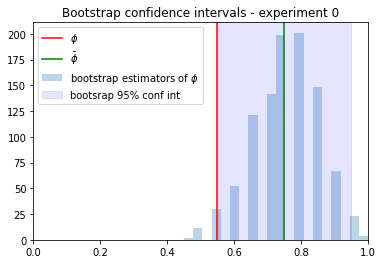

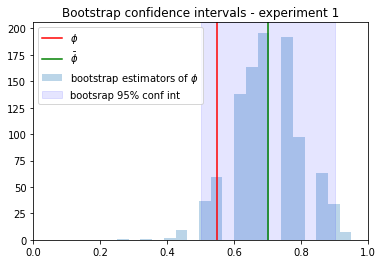

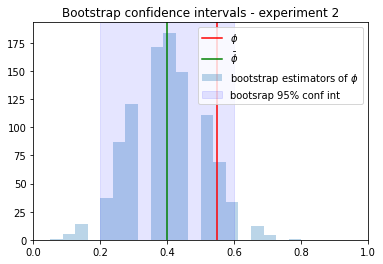

In [41]:
np.random.seed(1)
phi = 0.55  # The model parameter: true probability p(1)
n = 20  # The sample size

def bootstrap_experiment(n, phi):
    data = np.random.rand(n) < phi  # A single poll
    bar_phi = data.mean()  # the MLE estimator of phi in this single experiment

    n_bootstrap_rounds = 1000

    # sample answers with replacement
    bootstrap_idx = np.random.randint(low=0, high=n, size=(n_bootstrap_rounds, n))
    bootstrap_datasets = data[bootstrap_idx]
    
    bootstrap_phis = bootstrap_datasets.mean(1)

    # Estimate the confidence interval by taking the 2.5 and 97.5 percentiles
    sorted_bootstrap_phis = np.sort(bootstrap_phis)
    bootstrap_conf_low, bootstrap_conf_high = sorted_bootstrap_phis[
        [int(0.025 * n_bootstrap_rounds), int(0.975 * n_bootstrap_rounds)]]

    plt.figure()
    # plot the true, unknown parameter
    plt.axvline(phi, 0, 1, label=r'$\phi$', color='red')
    # plot the MLE
    plt.axvline(bar_phi, 0, 1, label=r'$\bar\phi$', color='green')
    # Plot the bootstrap estimates
    plt.hist(sorted_bootstrap_phis, bins=20, alpha=0.3, label=r'bootstrap estimators of $\phi$')
    # Plot the bootstrap 95% confidence interval
    plt.axvspan(bootstrap_conf_low, bootstrap_conf_high,
                alpha=0.1, label='bootsrap 95% conf int', color='blue')
    plt.legend()
    _ = plt.xlim(0, 1)

for exp_id in range(3):
    bootstrap_experiment(n, phi)
    plt.title(f'Bootstrap confidence intervals - experiment {exp_id}')

In the experiments we have used a low poll size, to make the results more extreme. Please note that the estimates we are getting vary a lot. However, the true value of $\phi$ seems to always fall within the predicted bounds. If repeated enough times, it should do so in 95% of experiments.

Let's appreciate for a moment the bootstrap results. We have a simple model, from which we are drawing samples. The results of our draw are quite varied and a priori we don't know how good is our estimation. However, we can apply a simple computational procedure which shows us the amount of variability in our results. We can aggregate it to fomulate a 95% confidence bounds: an interval in which the true parameter is in 95% of the experiments.

We could now try to design an experiment: find a sample size that would give us a desired width of the confidence interval, by trying several sizes and estimating the bootstrap confidence intervals. In the following demonstratoin observe how the confidence interval narrows with increased sample sizes.

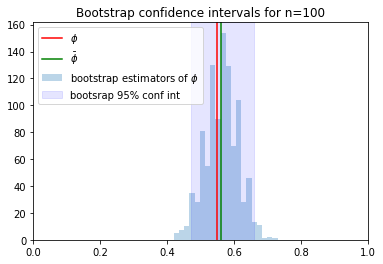

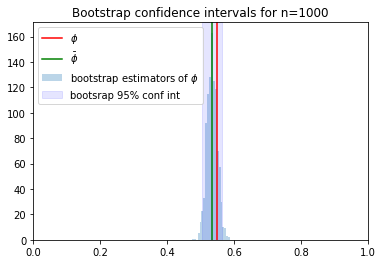

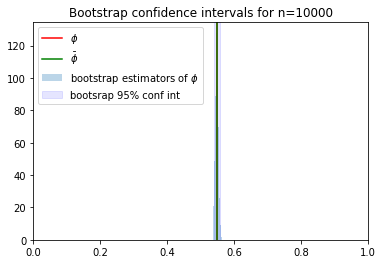

In [5]:
phi = 0.55

for n in [100, 1000, 10000]:
    bootstrap_experiment(n, phi)
    plt.title(f'Bootstrap confidence intervals for n={n}')

The fact that more samples give better estimations come from the Law of Big Numbers, which in our case states that with probability one the limit of $\bar\phi$ as $n$ goes to infinity is actually the $\phi$ itself.

0.54

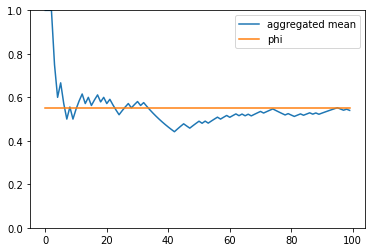

In [67]:
import pandas as pd
n = 100
d = pd.DataFrame(index=np.arange(n))
d["vote for A"] = np.random.rand(n) < phi
d["aggregated mean"] = d["vote for A"].expanding().mean()
d["phi"] = phi
d.plot(ylim=(0.,1.))
d["aggregated mean"].iloc[-1]

Even though the Law of Big numbers doesn't give us the speed of convergence, often we do have also bounds on the speed. Many times such methods follow by relating the distribution to a normal one, and below we shall see how such a relation can be used.

### Derivation of confidence intervals

We want the (sample dependent) confidence interval around the sample mean, such that in 95% of experiments (conducted polls), the true unknown population parameter $\phi$ is within the confidence interval.

Formally we want to find $\bar\phi$ and $\epsilon$ such that $p(\bar\phi-\epsilon \leq \phi \leq \bar\phi + \epsilon) > 0.95$ or, equivalently, such that $p(|\phi-\bar\phi| \leq \epsilon) > 0.95$.

To estimate this interval please recall that $\bar\phi$ is the fraction of successes and that $k=n\bar\phi$, the success count follows a binomial distribution.

$$
p\left(\bar\phi = \frac{k}{n}; n, \phi\right) = p\left(k\text{ successes in }n\text{ trials}; n, \phi\right)=\binom{n}{k}\phi^k(1-\phi)^{n-k}.
$$

The excpected number of successes $k$ is $n\phi$, because expectation is linear and we are summing $n$ Bernulli variables. Thus the expectation of $\bar\phi$ is 

$$
\mathbb{E}[\bar\phi] = \mathbb{E}\left[\frac{k}{n}\right] = \frac{n\phi}{n} = \phi.
$$

The variance of the number of successes $k$ is $n\phi(1-\phi)$ because it is the variance of the sum of $n$ _independent_ Bernoulli variables and variance is additice for independent variables. It follows that

$$
\text{var}[\bar\phi] = \frac{\text{var}[k]}{n^2} = \frac{n\phi(1-\phi)}{n^2} = \frac{\phi(1-\phi)}{n}.
$$

We see that as the sample size $n$ grows, variance of the sample mean is reduced.

For a large enough sample size, we can approximate the binomial distribution with a normal one with a matched mean and variance. This approximation is demonstrated in the plot below.


<ipython-input-6-f21efebed06b>:10: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(ks, model.pmf(ks), 'b', label='Binomial PMF', use_line_collection=True)


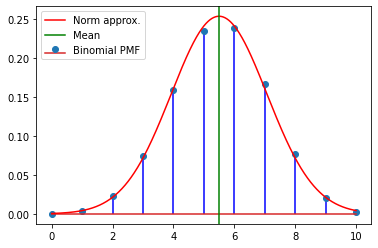

In [6]:
# model parameters
n = 10
phi = 0.55

# the binomial distribution
model = scipy.stats.binom(n=n, p=phi)
ks = np.arange(n+1)  # all possible success counts

# plot the PMF - probability mass function
plt.stem(ks, model.pmf(ks), 'b', label='Binomial PMF', use_line_collection=True)

# plot the normal approximation
k_mu = n*phi  # The expected value of k
k_stdev = np.sqrt(phi * (1 - phi) * n)  # The standard dev. of k
model_norm = scipy.stats.norm(k_mu, k_stdev)
x_cont = np.linspace(ks[0], ks[-1], 1000)
plt.plot(x_cont, model_norm.pdf(x_cont), 'r', label='Norm approx.')

plt.axvline(k_mu, 0, 1, color='g', label='Mean')

_ = plt.legend(loc='upper left')

#### Computing error bounds from normal approximation

We know that for a large enough sample (>15 persons) the random variable denoting the sample mean $\bar\phi$ is approximately normally distributed with mean $\phi$ and standard deviation $\sigma = \sqrt{(\phi(1-\phi)/n)}$. However we do not know $\phi$. When designing the experiment, we can take the value leading to the highest stadard deviation, which is 0.5. Alternatively, we can plug for $\phi$ the estimated sample mean $\bar\phi$. Note: this approach will be too optimistic, leading to too narrow confidence bounds. However the resulting error will be small.


From the following plot of the normal distribution we can see that $2\cdot(13.6+34.1)\% = 95.4\%$ of its probability mass falls into the range $\pm2\sigma$.  

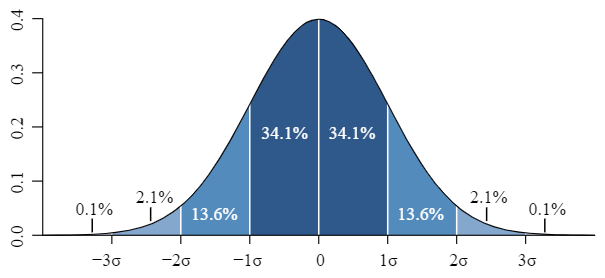

Thus, the approximate 95.4\% confidence interval for a Gaussian is $\pm2\sigma$. The 95\% interval is $\pm1.96\sigma$

In our case, the interval can be computed based on the standard deviation of $\bar\phi$, yielding $\pm1.96\sqrt{(\phi(1-\phi)/n)}$.

Assuming pessimistic $\phi=0.5$ we obtain 95\% conf interval $\approx 1.96\sqrt{0.5*0.5/n} \approx 1/\sqrt{n}$.

In the experiments below we are computing the confidence interval, then checking if the true value falls inside it. We report the fraction of experiments for which the true value was inside the interval.

Average confidence interval is phi_bar +-0.097
Out of 1000 experiments, the true phi fell into the confidence interval 952 times.


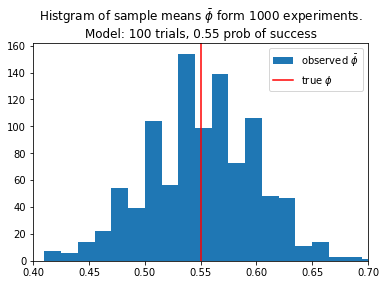

In [68]:
phi=0.55
n=100
n_experiments=1000

samples = np.random.rand(n_experiments, n)<phi
phi_bar = samples.mean(1)

plt.hist(phi_bar, bins=20, label=r'observed $\bar\phi$')
plt.axvline(phi, color='r', label=r'true $\phi$')
plt.title(r'Histgram of sample means $\bar\phi$ form %d experiments.' '\n'
          r'Model: %d trials, %.2f prob of success'%(n_experiments,n,phi))
plt.legend()
plt.xlim(phi-0.15, phi+0.15)

confidence_intervals = np.zeros((n_experiments, 2))
confidence_intervals[:,0] = phi_bar - 1.96 * np.sqrt(phi_bar * (1 - phi_bar) / n)
confidence_intervals[:,1] = phi_bar + 1.96 * np.sqrt(phi_bar * (1 - phi_bar) / n)

#note: this also works, can you explain how the formula works in numpy?
confidence_intervals2 = (
    phi_bar[:, None] + [-1.96, 1.96] * np.sqrt(phi_bar * (1 - phi_bar) / n).reshape(-1,1))
assert np.abs(confidence_intervals-confidence_intervals2).max()==0

good_experiments = (confidence_intervals[:, 0] <= phi) & (phi <= confidence_intervals[:, 1])

print ("Average confidence interval is phi_bar +-%.3f" 
       % ((confidence_intervals[:, 1] - confidence_intervals[:, 0]).mean() / 2.0,))

print ("Out of %d experiments, the true phi fell into the confidence interval %d times."
       % (n_experiments, good_experiments.sum()))

## Practical conclusions about polls
Practical outcome: in the worst case ($\phi=0.5$) the 95% confidence interval is $\approx\pm \sqrt{\frac{0.5(1-0.5)}{n}} = \pm \frac{1}{\sqrt{n}}$. To get the usually acceptable polling error of $\pm3$ percentage points, one needs to sample 1111 persons (because $(33\frac{1}{3})^2 \approx 1111$). Polling companies typically ask between 1000-3000 persons.

Questions:
1. How critical is the IID sampling assumption?
2. What do you think is a larger problem: approximating the PDF with a Gaussian distribution, or people lying in the questionnaire?

### A poll terribly gone bad.

In 1936 Literary Digest conducted a poll of more than 10 million votes, close to 1/4 of all americans allowed to vote in the Johnson vs Roosvelt presidential election. However, they did not account for the statistical biases in their data, wrongly predicting a landslide victory of Mr Johnson.

In the same year, a Mr Gallup condicted his own poll of 50000 americans, and properly predicted the victory of Mr Roosvelt (as well as the incorrect results of the Digest's poll).

18 months since then Literary Digest went bust, Gallup's company is still around.

This story highlight the importance of the IID sampling assumptions and the requirement of sample representativeness. Even a masive poll will yield wrong results, if the people questioned do not represent the society.

This is an important lesson to the ML practitioners: getting good data is important, so is validating our assumptions about it!.

## Bayesian reasoning

The MLE estimator fails for really small sample sizes. Suppose you visit a country before their elections, ask one person and want to estimate who's leading. The MLE will put 100% on either extreme! However, from experience you know, that no society is so homegenous that 100% will vote for the same candidate. 

This leads us to another view of estimating model parameters: one in which we reason about our beliefs, and how they change when new evidence (e.g. a new poll) arrives.

Intuitively, we will maintain a belief about the world, expressed as a probability distribution. E.g. if I asked you today, each one of you would maintain a $p(\phi)$ describing your belief about the popularity of the president of Poland. Since this belief didn't involve any data, we call it a _prior belief_, that is one that have before, or prior to, seeing any data.

I now show you a poll result. It's mean is $\bar\phi$. You probably will not change your belief to fully match the poll's result. You will, however, incorporate this result into you belief and change it slightly. This will be your _posterior belief_, $p(\phi|\text{poll})$ i.e. the updated belief formed after seing the data.

The prior and posterior belief are tied by the Bayes theorem:

$$
p(\phi|\text{poll}) = \frac{p(\text{poll}|\phi)p(\phi)}{p(\text{poll})} = \frac{1}{Z}p(\text{poll}|\phi)p(\phi),
$$
where $Z=p(\text{poll})$ is a normalization term which does not depend on $\phi$.

Notice that the Bayes update contains the likelihood term $p(\text{poll}|\phi)$. This time, however:
- we are not returning a single value for $\phi$, but a full probability distribution
- we mix together the prior and the likelihood.

We also need to compute the normalization constant $Z$. It is often intractable computationally. In the folowing example, we will choose a prior that will make it easy to compute $Z$. This convenience prior is called a _conjugate_ one. We will use the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) because it is flexible, and it has a form similar to the likelihood term.

The Beta distribution with parameters $\alpha$ and $\beta$ is defined on the interval $[0,1]$ and takes the form:

$$
p(x; \alpha, \beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha,\beta)},
$$
where $B$ is a special function that comutes the normalization constant.

The plot below shows a few PDFs that the Beta distribution can express. As you can see, we can model a uniform distribution over $[0,1]$ as well as localize the belief around a given value. 

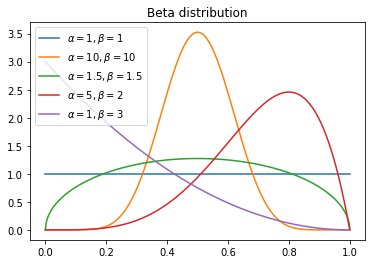

In [8]:
support = np.linspace(0,1,512)

for A,B in [(1,1), (10,10), (1.5, 1.5), (5,2), (1,3)]:
    plt.plot(support, scipy.stats.beta.pdf(support, A,B), label=rf"$\alpha={A}, \beta={B}$")
plt.title("Beta distribution")
plt.legend()

We will now work out a rule for updating our belief. Suppose you have seen a poll with $k$ supporters out of $n$ persons. We have:
$$\begin{split}
p(\phi) &\propto \phi^{\alpha-1}(1-\phi)^{\beta-1} \\
p(k; n, \phi) &\propto \phi^k (1-\phi)^{n-k}
\end{split}$$

the product $p(k; n, \phi)p(\phi)$ is:
$$
p(k; n, \phi)p(\phi) = \phi^{k + \alpha-1}(1-\phi)^{n -k + \beta-1}
$$

note that, up to the scaling constant, it is a $\text{Beta}(k + \alpha, n -k + \beta)$!

Thus our Bayesian polling system is quite simple:
- we start with a prior belief, given by $\alpha, \beta$.
- each time we see a poll with $k$ supporters oit of $n$ we update the Beta's parameters to $(k + \alpha, n -k + \beta)$.

Plese note, how $\alpha$ and $\beta$ are added to the counts. In fact, we often call them _pseudocounts_ - they behave as some extra data that we have not seen, but which we assume to be there.

We will now run a Bayesian simulation, collecting samples and updating our belief about $p$.

In [85]:
phi = 0.55

A = 1
B = 1

n_successes = 0
n_failures = 0

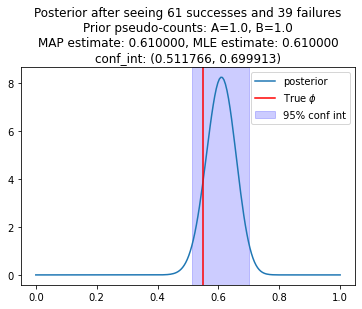

In [86]:
for _ in range(100):
    if np.random.rand() < phi:
        n_successes += 1
    else:
        n_failures += 1

support=np.linspace(0, 1, 200)
plt.plot(support, scipy.stats.beta.pdf(support, A + n_successes, B + n_failures), 
         label='posterior')
plt.axvline(phi, color='r', label=r'True $\phi$')
# We get the confidence intervals from quantiles of the Beta distribution
conf_int_low, conf_int_high = scipy.stats.beta.ppf(
    (0.025,0.975), A + n_successes, B + n_failures)
plt.axvspan(conf_int_low, conf_int_high, alpha=0.2, label='95% conf int', color='b')
plt.title("Posterior after seeing %d successes and %d failures\n"
          "Prior pseudo-counts: A=%.1f, B=%.1f\n"
          "MAP estimate: %f, MLE estimate: %f\n"
          "conf_int: (%f, %f)"% (n_successes, n_failures, A, B, 
                                 1.0*(A+n_successes-1)/(A+n_successes+B+n_failures-2),
                                 1.0*n_successes/(n_successes+n_failures),
                                 conf_int_low, conf_int_high))
_ = plt.legend()

In summary: in the Bayesian framework we treat the quantities we want to estimate as random variables, to which we attach probability distributions.

We need to define our prior beliefs. In the example, the prior was a Beta distribution.

After seeing the data we update our belief about the world. In the example, this was easy - we keep running counts of the number of failures and successes observed. We update them seeing the data. The prior conveniently can be treated as *pseudo-counts*. 

To summarize the distribution over the parameter to one number, we typically take its mode (the most likely value), this approach is called MAP (Maximum a Posteriori).

## From Bayesian parameter estimation to regularized linear regression

We have shown above that one can interpret the least squares criterion used to train a linear regression model as fitting a MLE estimator of $\Theta$ under a Gaussian noise assumption.

We will not generalize this approach to justifying the regularized linear regression.

Suppose we have a small data set. However, we have a prior belief about the parameters of linear regression. We can for instance assume, that no feature should have a weight which is much larger than the other ones. This corresponds to a prior belief that:
$$
p(\Theta) = \prod_j p(\Theta_j)=\mathcal{N}(0, \sigma_\Theta).
$$

We will keep also keep the Gaussian likelihood term:
$$
p(\text{Data}; \Theta) = \prod_{i=1}^N p(y^{(i)}|x^{(i)};\Theta) 
$$

Our posterior belief is thus proportional to 
$$\begin{split}
p(\Theta|\text{Data}) &= \frac{1}{Z}p(\text{Data}; \Theta)p(\Theta) \\
&=\frac{1}{Z}\prod_{i=1}^N p(y^{(i)}|x^{(i)};\Theta) \; \prod_j p(\Theta_j)
\end{split}$$

The MAP (maximum a posteriori) solution calls for finding a $\Theta$ which maximizes this posterior. We can again derive a cost funtion by:
1. taking the log
2. applying the negation

$$\begin{split}
J(\Theta) &= -\log\left[\frac{1}{Z}p(\text{Data}; \Theta)p(\Theta)\right] \\
&= -\log\left[\frac{1}{Z}\prod_{i=1}^N p(y^{(i)}|x^{(i)};\Theta) \; \prod_j p(\Theta_j)\right] \\
&=\log{}Z - \sum_{i=1}^{N}\left[\log\frac{1}{\sqrt{2\pi}\sigma} - \frac{(y^{(i)}-x^{(i)}\Theta)^2}{2\sigma^2}\right] -\sum_{j}\left[\log\frac{1}{\sqrt{2\pi}\sigma_\Theta} - \frac{\Theta_j^2}{2\sigma_\Theta^2}\right] \\
&= C + \lambda_1\sum_{i=1}^{N}(y^{(i)}-x^{(i)}\Theta)^2 + \lambda_2\sum_j\Theta_j^2,
\end{split}$$
where $C, \lambda_1$, and $\lambda_2$ are constants, with $\lambda$s depending on the assumed standard deviations.

We can see that this corresponds to minimizng
$$
\sum_{i=1}^{N}(y^{(i)}-x^{(i)}\Theta)^2 + \lambda\sum_j\Theta_j^2
$$
with an appropriately chosen $\lambda$. 

Therefore, the regularized linear regression corresponds to performing MAP estimation of $\Theta$ under a normal prior assumption.

In the following lectures we will see the impact of using a different prior, such as the Laplace distribution.

## Summary

We have seen today that Machine Learning is solves a similar problem to statistics: it finds models that describe the observed data, and we can interpret popular Machine Learnign methods as performing MLE or MAP inference.

Thus, Machine Learning models make formal assumptions about the data they model. These assumptions should be verified.

One of the core asusmptions is that our training and testing sets are IID. This is often not the case. If this assumption is severely unjistified, no approach will work, and your machine learning models will fail just like the gigantic Literary Digest poll. Machine Learning is about making approximations, and you must know and be conscious about the approximations and errors in data!

